# Multifocal generation with Adam optimizer

### This optimization model is non-convex. We select the Adam optimizer, a stochastic optimization algorithm to find a satisfactory solution.

## 0. Some preparations

This notebook has been tested to be executable in the environment listed as below: 
- ubuntu 16.04 
- python 3.6
- tensorflow-gpu 1.4.0 
- NVIDIA GPU + CUDA 8.0

Please check your environment before run this notebook. If your environment is not consistent, we suggest you configure a same envoronment to avoid some annoying errors caused by version incompatibility of Tensorflow platform.

## 1. Set up the forward model

In [1]:
import numpy as np
from scipy import special
import math
import matplotlib.pyplot as plt
% matplotlib inline

### Set the parameters about your optical system here

In [2]:
# input parameters
N_pupil = 800 # pixel number of pupil
N_focal = 100 # pixel number of focal
N_spot = 8 # pixel number of z
N_depth = 500 # for final confirm

spot_distance = 50e-6 # spot interval
pixel_rho = 0.5e-5 # pixel size in pupil plane
pixel_r = 0.2e-6 # pixel size in focal plane
pixel_z = 1e-6 # pixel size along z-axis
bias = 0e-6 # bias term
sum_area = 5e-6 #  window size, for calculate the foci intensity in the focal plane

# physical parameter
f = 7.32e-3 # focal length of the objective
wavelength = 920e-9 # wave length
NA = 0.5
n_obj= 1.33 # refractive index
w0 = 5e-3 # incident beam waist radius, 
scat_length = 180e-6 # scattering depth

k0 = 2 * math.pi / wavelength
r_obj = NA /n_obj * f # diameter of back pupil

In [3]:
# coordinate
rho_index = np.array(range(0, N_pupil)) * pixel_rho # coordinate of pupil
r_index = np.array(range(0,N_pupil)) * pixel_r # coordinate of focal
depth_array = (np.array(range(1,N_depth + 1)) - N_depth / 2) * pixel_z

# test
print(rho_index.shape)
print(r_index.shape)
print(depth_array.shape) # note it's column vector

(800,)
(800,)
(500,)


In [4]:
# spot position and intensity
depth_ind = np.zeros([N_spot]); # depth index in the original array
intensity_weight = np.zeros([N_spot]); # intensity weight of each foci
spot_depth_indx = np.zeros([N_spot]); # depth of each foci
if np.mod(N_spot, 2) == 0:
    for i in range(0, N_spot):
        spot_depth_indx[i] = spot_distance * (i + 1 - N_spot / 2 - 0.5) + bias
        depth_ind[i] = np.int(spot_depth_indx[i] / pixel_z + N_depth / 2)
        intensity_weight[i] = np.exp(-2 * spot_distance * (i + 1) / scat_length) # note: for two-photon, the intensity would be doubled
else:
    for i in range(0, N_spot):
        spot_depth_indx[i] = spot_distance * (i + 1 - (N_spot + 1) / 2) + bias
        depth_ind[i] = np.int(spot_depth_indx[i] / pixel_z + N_depth / 2)
        intensity_weight[i] = np.exp(-2 * spot_distance * (i + 1) / scat_length)
        
# print spot location
print('spot dpeth in micro', spot_depth_indx*1e6)
print('spot dpeth in index', depth_ind)
print('intensity weights', intensity_weight)

spot dpeth [-1.75e-04 -1.25e-04 -7.50e-05 -2.50e-05  2.50e-05  7.50e-05  1.25e-04
  1.75e-04]
[ 75. 124. 175. 225. 275. 325. 375. 425.]
[0.57375342 0.32919299 0.1888756  0.10836802 0.06217652 0.03567399
 0.02046808 0.01174363]


### Define energy distribution of the input beam

Text(0.5,1,'pupil plane')

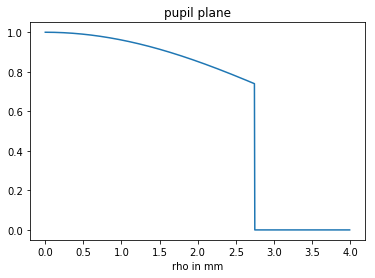

In [5]:
# define input beam
gaussian_mask = np.exp(-np.power(rho_index / w0, 2));
pupil =np.ones(N_pupil) * gaussian_mask;
pupil_cut_ind = (np.abs(rho_index- r_obj)).argmin(); # find the nearest value in the rho coordinate
pupil[pupil_cut_ind:] = 0;

plt.plot(rho_index * 1e3, pupil)
plt.xlabel('rho in mm')
plt.title('pupil plane')

In [6]:
# summing area
focal_sum_ind = (np.abs(r_index- sum_area)).argmin(); # find the nearest value in the rho coordinate

In [7]:
# forward matrix
H_matrix = special.jv(0, -k0 * np.matmul(r_index.reshape(-1, 1), rho_index.reshape(1, -1)) / f)
print(H_matrix.shape)
simplfied_matrix = H_matrix[:focal_sum_ind, :]
print(simplfied_matrix.shape)

(800, 800)
(25, 800)


### Test the forward model

Text(0.5,0,'z axis um')

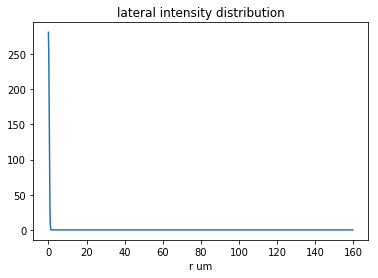

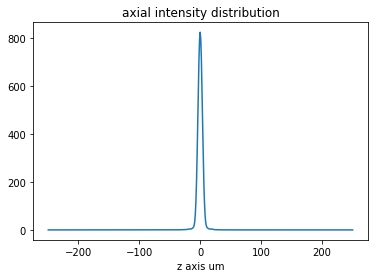

In [8]:
# test forward model
Phi = np.zeros(N_pupil)
buf1 = 2 * math.pi * rho_index * np.exp(1j * Phi) *  pupil # size: (N_pupil,)
buf1_exp = np.tile(
    buf1.reshape(1, -1), 
    (N_depth, 1)
) # size: [N_depth, N_pupil];
buf2 = np.exp(
    1j * k0 * 
    np.matmul(depth_array.reshape(-1, 1), (np.power(rho_index, 2)).reshape(1, -1))
    / 2 / f/f) # size: [N_depth, N_pupil];
buf3 = buf2 * buf1_exp # size: [N_spot, N_pupil];

h_psf = np.matmul(buf3, np.transpose(H_matrix)) # size: [N_spot, focal_sum_ind];

axial_intensity = np.sum(np.power(np.abs(h_psf), 4), 1)# should divided the guided intensity
lateral_intensity = np.power(np.abs(h_psf[np.int(N_depth / 2 - 1),]), 4)

plt.figure(1)
plt.plot(r_index * 1e6, lateral_intensity)
plt.title('lateral intensity distribution')
plt.xlabel('r um')

plt.figure(2)
plt.plot(depth_array * 1e6, axial_intensity)
plt.title('axial intensity distribution')
plt.xlabel('z axis um')

### 2. Run optimization

In [9]:
import tensorflow as tf

C:\Users\smile\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
def compl_exp_tf(phase, dtype=tf.complex64, name='complex_exp'):
    """Complex exponent via euler's formula, since Cuda doesn't have a GPU kernel for that.
    Casts to *dtype*.
    """
    phase = tf.cast(phase, tf.float64)
    return tf.add(tf.cast(tf.cos(phase), dtype=dtype),
                  1.j * tf.cast(tf.sin(phase), dtype=dtype),
                  name=name)

In [11]:
# define phase as a variable
# should be initialized by a spherical function
phase_spherical = np.angle(np.exp(1j * k0 * bias * np.power(rho_index[:pupil_cut_ind], 2) / 2 / f/ f)) / 2 / np.pi
x = tf.Variable(initial_value=phase_spherical, name='Phi', dtype=tf.float32, constraint=lambda t: tf.clip_by_value(t, 0, 1)) # valid part in pupil plane

In [12]:
# some variables that needs not to be changed
tf_rho_index = tf.constant(rho_index)
tf_pupil = tf.constant(pupil)
tf_simplfied_matrix = tf.cast(tf.constant(np.transpose(simplfied_matrix)), tf.complex64)

buf2 = np.exp(
    1j * k0 * 
    np.matmul(spot_depth_indx.reshape(-1, 1), (np.power(rho_index, 2)).reshape(1, -1))
    / 2 / f/f) # size: [N_spot, N_pupil];
tf_buf2 = tf.constant(buf2, dtype=tf.complex64)


In [13]:
# phase
# tf.shape(x)
# tf.cast(x, tf.float64)
# tf.cast(tf.zeros([N_pupil - pupil_cut_ind]), tf.float64)
tf_Phi = tf.concat([x * 2 * np.pi, tf.zeros([N_pupil - pupil_cut_ind])], 0)
tf.shape(tf_Phi)

<tf.Tensor 'Shape:0' shape=(1,) dtype=int32>

In [14]:
# calculation buf1
tf_buf11 =tf.multiply(tf_rho_index, tf_pupil)
tf_buf12 = tf.cast(tf_buf11, tf.complex64)
tf_buf1 = 2 * np.pi * tf.multiply(tf_buf12, compl_exp_tf(tf_Phi)) # size: (N_pupil,)

tf.shape(tf_buf1) # size: (N_pupil,)

<tf.Tensor 'Shape_1:0' shape=(1,) dtype=int32>

In [15]:
# calculation buf1_exp
tf_buf1_exp = tf.matmul(tf.reshape(tf.cast(tf.ones([N_spot, 1]), tf.complex64), [-1, 1]), tf.reshape(tf_buf1, [1, -1])) # size: [N_spot, N_pupil], broadcast;
tf.shape(tf_buf1_exp) 

<tf.Tensor 'Shape_2:0' shape=(2,) dtype=int32>

In [16]:
# calculate buf3
tf_buf3 = tf.multiply(tf_buf2, tf_buf1_exp) # size: [N_spot, N_pupil];

In [17]:
# calculate PSF
tf_h_psf = tf.matmul(tf_buf3, tf_simplfied_matrix) # size: [N_spot, focal_sum_ind];

In [18]:
# define axial intensity
tf_axial_intensity = tf.reduce_sum(tf.pow(tf.abs(tf_h_psf), 4), axis=1)# so here its 2P intensity

In [19]:
# define lambda
lambda_1 = 1
lambda_2 = 10
lambda_3 = 1e3
n_round = 300000

In [20]:
# define learning rate
ada_learning_rate = 1e-3

In [21]:
# define loss
loss_1 = -tf.reduce_sum(tf_axial_intensity)
loss_2 = tf.reduce_max(tf_axial_intensity * intensity_weight) / tf.reduce_min(tf_axial_intensity * intensity_weight)
loss_3 = tf.keras.backend.std(tf_axial_intensity * intensity_weight)
# loss_3 = -tf.reduce_sum(tf.slice(tf_axial_intensity, [-1], [1]) # last element
# tf.shape(loss_1)
# tf.shape(loss_2)
loss = tf.add(
    tf.add(tf.cast(lambda_1 * loss_1, tf.float64), 
                     tf.cast(lambda_2 * loss_2, tf.float64)), 
                     tf.cast(lambda_3 * loss_3, tf.float64))

In [22]:
## optimization1
optimizer = tf.train.AdamOptimizer(ada_learning_rate)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    print("starting at", "cost: ", sess.run(loss))
    loss_array =np.array([])
    for i in range(1, n_round):
        sess.run(train)
        loss_array = np.append(loss_array, sess.run(loss))
        if not np.mod(i, np.int(n_round / 10)):
            print("step:", i, "cost:", sess.run(loss), "loss1:", 
                  sess.run(loss_1), "loss2:", sess.run(loss_2), "loss3:", sess.run(loss_3))

    output_phase = sess.run(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
starting at cost:  123566.09169316292
step: 30000 cost: -70.50001776218414 loss1: -81.39184 loss2: 1.0066525 loss3: 0.0008252958
step: 60000 cost: -106.17712378501892 loss1: -117.16078 loss2: 1.0058278 loss3: 0.00092538
step: 90000 cost: -107.55162966251373 loss1: -118.61158 loss2: 1.0056214 loss3: 0.0010037359
step: 120000 cost: -107.89044517278671 loss1: -118.62717 loss2: 1.0043657 loss3: 0.0006930643
step: 150000 cost: -107.44330847263336 loss1: -118.6698 loss2: 1.0061777 loss3: 0.0011647142
step: 180000 cost: -108.14122194051743 loss1: -118.67059 loss2: 1.002825 loss3: 0.00050112157
step: 210000 cost: -107.6758326292038 loss1: -118.69222 loss2: 1.0053195 loss3: 0.000963195
step: 240000 cost: -107.73123961687088 loss1: -118.705124 loss2: 1.0047783 loss3: 0.0009261014
step: 270000 cost: -107.76016062498093 loss1: -118.69316 loss2: 1.00493 loss3: 0.0008837002


### 3. Evaludation


Text(0,0.5,'rad')

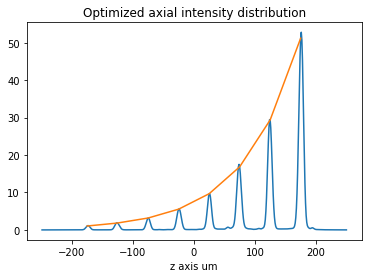

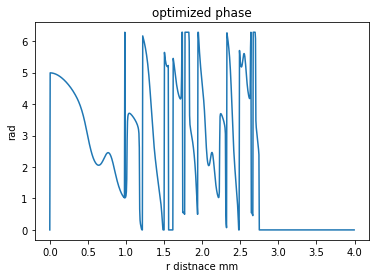

In [23]:
Phi = np.zeros(N_pupil)
Phi[:pupil_cut_ind] = output_phase
buf1 = 2 * math.pi * rho_index * np.exp(1j * Phi * 2 * np.pi) *  pupil # size: (N_pupil,)
buf1_exp = np.tile(
    buf1.reshape(1, -1), 
    (N_depth, 1)
) # size: [N_depth, N_pupil];
buf2 = np.exp(
    1j * k0 * 
    np.matmul(depth_array.reshape(-1, 1), (np.power(rho_index, 2)).reshape(1, -1))
    / 2 / f/f) # size: [N_depth, N_pupil];
buf3 = buf2 * buf1_exp # size: [N_spot, N_pupil];

h_psf = np.matmul(buf3, np.transpose(H_matrix)) # size: [N_spot, focal_sum_ind];

axial_intensity = np.sum(np.power(np.abs(h_psf), 4), 1)# should divided the guided intensity
lateral_intensity = np.power(np.abs(h_psf[np.int(N_depth / 2 - 1),]), 4) # still 2P

fig1 = plt.figure(1)
plt.plot(depth_array * 1e6, axial_intensity)
plt.hold
plt.plot(depth_array[depth_ind.astype(np.int16) - 1] * 1e6, axial_intensity[depth_ind[0].astype(np.int16) - 1] / intensity_weight * intensity_weight[0])
plt.title('Optimized axial intensity distribution')
plt.xlabel('z axis um')

fig2 = plt.figure(2)
plt.plot(rho_index * 1e3, Phi * 2 * np.pi)
plt.title('optimized phase')
plt.xlabel('r distnace mm')
plt.ylabel('rad')

In [24]:
## generate 2d phase
phase_2d = np.zeros([2 * pupil_cut_ind, 2 * pupil_cut_ind])
for theta_index in range(0, pupil_cut_ind * 2): # azimuth angle
    theta = theta_index / (pupil_cut_ind * 2) * 2 * np.pi
    for r_ind in range(0, pupil_cut_ind): # radius
        i = np.max([
            np.min(
                [np.int(r_ind * np.cos(theta) + pupil_cut_ind), 2 * pupil_cut_ind]
            ), 
            0])
        j = np.max([
            np.min(
                [np.int(r_ind * np.sin(theta) + pupil_cut_ind), 2 * pupil_cut_ind]
            ), 
            0])
        phase_2d[i, j] = Phi[r_ind]
phase_2d *= 2 *np.pi 

(-0.5, 1099.5, 1099.5, -0.5)

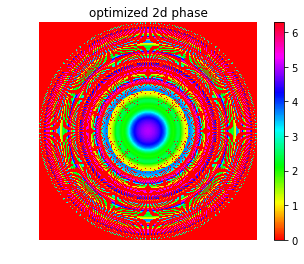

In [25]:
# plot phase mask
fig3 = plt.figure(3)
plt.imshow(phase_2d, cmap='hsv')
plt.title('optimized 2d phase')
plt.colorbar()
plt.axis('off')

### 4. save results

In [26]:
import os
import scipy.io as sio

In [27]:
# build target folder
target_dir = "Ada_results/simulation/foci_{0}/dis_{1:.0f}um/" .format(N_spot, spot_distance * 1e6)
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

In [28]:
# save the phase pattern
sio.savemat('{0}/1d_phase_cut.mat'.format(target_dir), {'phase_cut': (output_phase * 2 * np.pi)})
sio.savemat('{0}/1d_phase_full.mat'.format(target_dir), {'phase_full': (Phi * 2 * np.pi)})

In [29]:
# save simulation parameters
with open("{0}/Parameters.txt".format(target_dir), "w") as text_file:
    text_file.write("N_pupil: %.0f \n" % N_pupil)
    text_file.write("N_focal: %.0f \n" % N_focal)
    text_file.write("pixel_rho: %.2f um \n" % (pixel_rho*1e6))
    text_file.write("pixel_r: %.2f \n" % (pixel_r*1e6))
    text_file.write("f: %.2f mm \n" % (f * 1e3))
    text_file.write("wavelength: %.0f \n" % (wavelength * 1e9))
    text_file.write("NA: %.2f \n" % NA)
    text_file.write("n_obj: %.2f \n" % n_obj)
    text_file.write("input_w0: %.2f mm \n" % (w0 * 1e3))
    text_file.write("lambda_loss_energy: %.2f \n" % lambda_1)
    text_file.write("lambda_loss_max_min: %.2f \n" % lambda_2)
    text_file.write("ada_learning_rate: %.5f \n" % ada_learning_rate)

In [30]:
# save figures
fig1.savefig('{0}/axial_distribution.png'.format(target_dir), dpi=220)
fig2.savefig('{0}/1d_phase.png'.format(target_dir), dpi=220)
fig3.savefig('{0}/2d_phase.png'.format(target_dir), dpi=220, bbox_inches='tight')

In [31]:
np.cos(np.pi)

-1.0

In [32]:
spot_depth_indx

array([-1.75e-04, -1.25e-04, -7.50e-05, -2.50e-05,  2.50e-05,  7.50e-05,
        1.25e-04,  1.75e-04])